# LSTM/GRU classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import itertools
from nltk.corpus import stopwords
from collections import Counter

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.data import Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, concatenate, LSTM, GRU, Input, Embedding, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall


In [38]:
df = pd.read_csv('data/music_dataset_final_hopefully.csv', index_col=0).drop(columns=['lyrics'])
print(df.shape)
df.head()

(4955, 56)


,track,artist,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,spotify_id,seeds_array,artist_name,track_name,...,Dance,Country,Opera,Movie,Children's Music,A Capella,artist_track,genius_url,new_lyrics,sentiment
0,'Till I Collapse,Eminem,6,4.550000,5.273125,5.690625,4xkOaSrkexMciUUogZKVTS,['aggressive'],Eminem,'Till I Collapse,...,0,0,0,0,0,0,Eminem 'Till I Collapse,https://genius.com/Eminem-till-i-collapse-lyrics,[Intro: Eminem]\r\n'Cause sometimes you just f...,intense_aggressive
1,St. Anger,Metallica,8,3.710000,5.833000,5.427250,3fOc9x06lKJBhz435mInlH,['aggressive'],Metallica,St. Anger,...,0,0,0,0,0,0,Metallica St. Anger,https://genius.com/Metallica-st-anger-lyrics,[Verse]\r\nSaint Anger 'round my neck\r\nSaint...,intense_aggressive
2,Die MF Die,Dope,7,3.771176,5.348235,5.441765,5bU4KX47KqtDKKaLM4QCzh,['aggressive'],Dope,Die MF Die,...,0,0,0,0,0,0,Dope Die MF Die,https://genius.com/Dope-die-mf-die-lyrics,[Intro]\r\nDie!\r\n[Verse 1]\r\nI don't need y...,intense_aggressive
3,Step Up,Drowning Pool,9,2.971389,5.537500,4.726389,4Q1w4Ryyi8KNxxaFlOQClK,['aggressive'],Drowning Pool,Step Up,...,0,0,0,0,0,0,Drowning Pool Step Up,https://genius.com/Drowning-pool-step-up-lyrics,"[Intro]\r\nOne, two, three, go!\r\n[Verse 1]\r...",intense_aggressive
4,Feedback,Kanye West,1,3.080000,5.870000,5.490000,49fT6owWuknekShh9utsjv,['aggressive'],Kanye West,Feedback,...,0,0,0,0,0,0,Kanye West Feedback,https://genius.com/Kanye-west-feedback-lyrics,"[Chorus]\r\nAyy, ya heard about the good news?...",intense_aggressive


In [3]:
df.columns

Index(['track', 'artist', 'number_of_emotion_tags', 'valence_tags',
       'arousal_tags', 'dominance_tags', 'spotify_id', 'seeds_array',
       'artist_name', 'track_name', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence', 'genres', 'Comedy', 'Soundtrack', 'Indie',
       'Jazz', 'Pop', 'Electronic', 'Children’s Music', 'Folk', 'Hip-Hop',
       'Rock', 'Alternative', 'Classical', 'Rap', 'World', 'Soul', 'Blues',
       'R&B', 'Anime', 'Reggaeton', 'Ska', 'Reggae', 'Dance', 'Country',
       'Opera', 'Movie', 'Children's Music', 'A Capella', 'artist_track',
       'genius_url', 'new_lyrics', 'sentiment'],
      dtype='object')

In [39]:
df = df.rename(columns={'new_lyrics': 'lyrics'})
df.head()

,track,artist,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,spotify_id,seeds_array,artist_name,track_name,...,Dance,Country,Opera,Movie,Children's Music,A Capella,artist_track,genius_url,lyrics,sentiment
0,'Till I Collapse,Eminem,6,4.550000,5.273125,5.690625,4xkOaSrkexMciUUogZKVTS,['aggressive'],Eminem,'Till I Collapse,...,0,0,0,0,0,0,Eminem 'Till I Collapse,https://genius.com/Eminem-till-i-collapse-lyrics,[Intro: Eminem]\r\n'Cause sometimes you just f...,intense_aggressive
1,St. Anger,Metallica,8,3.710000,5.833000,5.427250,3fOc9x06lKJBhz435mInlH,['aggressive'],Metallica,St. Anger,...,0,0,0,0,0,0,Metallica St. Anger,https://genius.com/Metallica-st-anger-lyrics,[Verse]\r\nSaint Anger 'round my neck\r\nSaint...,intense_aggressive
2,Die MF Die,Dope,7,3.771176,5.348235,5.441765,5bU4KX47KqtDKKaLM4QCzh,['aggressive'],Dope,Die MF Die,...,0,0,0,0,0,0,Dope Die MF Die,https://genius.com/Dope-die-mf-die-lyrics,[Intro]\r\nDie!\r\n[Verse 1]\r\nI don't need y...,intense_aggressive
3,Step Up,Drowning Pool,9,2.971389,5.537500,4.726389,4Q1w4Ryyi8KNxxaFlOQClK,['aggressive'],Drowning Pool,Step Up,...,0,0,0,0,0,0,Drowning Pool Step Up,https://genius.com/Drowning-pool-step-up-lyrics,"[Intro]\r\nOne, two, three, go!\r\n[Verse 1]\r...",intense_aggressive
4,Feedback,Kanye West,1,3.080000,5.870000,5.490000,49fT6owWuknekShh9utsjv,['aggressive'],Kanye West,Feedback,...,0,0,0,0,0,0,Kanye West Feedback,https://genius.com/Kanye-west-feedback-lyrics,"[Chorus]\r\nAyy, ya heard about the good news?...",intense_aggressive


## Dataset prep

In [7]:
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def transform_lyrics(row):
    base_lyrics = row['lyrics']
    artist_name = row['artist']
    track_title = row['track']
    
    lyrics = base_lyrics.replace("\r", " ")
    
    lyrics = re.sub(r"\[([^\]]+)\]", "", lyrics)
    
    lines = lyrics.split('\n')
    lines = list(dict.fromkeys(lines)) # cannot use set for unique verses cause it doesn't keep order

    lines = [line for line in lines if line is not None and line != '' and line != ' ']
    lyrics = ' '.join(lines)
    
    lyrics = track_title + "  " + artist_name + " " + lyrics 
    lyrics = lyrics.lower()

    # Clean the lyrics
    lyrics = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", lyrics)
    lyrics = re.sub(r"what's", "what is ", lyrics)
    lyrics = re.sub(r"\'s", " ", lyrics)
    lyrics = re.sub(r"\'ve", " have ", lyrics)
    lyrics = re.sub(r"can't", "cannot ", lyrics)
    lyrics = re.sub(r"n't", " not ", lyrics)
    lyrics = re.sub(r"ain't", "am not ", lyrics)
    lyrics = re.sub(r"i'm", "i am ", lyrics)
    lyrics = re.sub(r"\'re", " are ", lyrics)
    lyrics = re.sub(r"\'d", " would ", lyrics)
    lyrics = re.sub(r"\'ll", " will ", lyrics)
    lyrics = re.sub(r",", " ", lyrics)
    lyrics = re.sub(r"\.", " ", lyrics)
    lyrics = re.sub(r"!", " ! ", lyrics)
    lyrics = re.sub(r"\/", " ", lyrics)
    lyrics = re.sub(r"\^", " ^ ", lyrics)
    lyrics = re.sub(r"\+", " + ", lyrics)
    lyrics = re.sub(r"\-", " - ", lyrics)
    lyrics = re.sub(r"\=", " = ", lyrics)
    lyrics = re.sub(r"'", " ", lyrics)
    lyrics = re.sub(r"(\d+)(k)", r"\g<1>000", lyrics)
    lyrics = re.sub(r":", " : ", lyrics)
    lyrics = re.sub(r" e g ", " eg ", lyrics)
    lyrics = re.sub(r" b g ", " bg ", lyrics)
    lyrics = re.sub(r" u s ", " american ", lyrics)
    lyrics = re.sub(r"\0s", "0", lyrics)
    lyrics = re.sub(r" 9 11 ", "911", lyrics)
    lyrics = re.sub(r"e - mail", "email", lyrics)
    lyrics = re.sub(r"j k", "jk", lyrics)
    lyrics = re.sub(r"'s", "", lyrics)
    lyrics = re.sub(r"[\(\)]", "", lyrics)
    lyrics = re.sub(r"\s{2,}", " ", lyrics)
    
    lyrics = ' '.join([word for word in lyrics.split() if word not in stops])
      
    return lyrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df['lyrics'] = df.apply(transform_lyrics, axis=1)

In [9]:
df['lyrics'][0]

'till collapse eminem cause sometimes feel tired yo left yo left feel weak feel weak yo left right left feel like wanna give yo left yo left gotta search within try find inner strength pull shit get motivation give quitter matter bad wanna fall flat face collapse til collapse spillin raps long feel em til day drop never say killin em cause stop pennin em hip - hop eminem subliminal thoughts stop sendin em women caught webs spin em hock venom adrenaline shots penicillin could get illin stop amoxicillin real enough criminal cop - killin hip - hop villain minimal swap cop millions pac listeners comin feel gonna fear like showed ya spirit god lives us hear lot lyrics shock miracle product pop fizzin fa shizzle wizzle plot listen bizzles forgot slizzle give fuck til roof comes til lights go til legs give cannot shut mouth til smoke clears high perhaps rip shit til bones collapse roof roof roof comes roof comes legs legs give underneath music like magic certain feelin get real spit people fe

In [10]:
unique_words = set()
for text in df['lyrics']:
    unique_words = unique_words.union(text.lower().split())

print(f'Velicina vokabulara: {len(unique_words)}')

Velicina vokabulara: 29921


<Axes: >

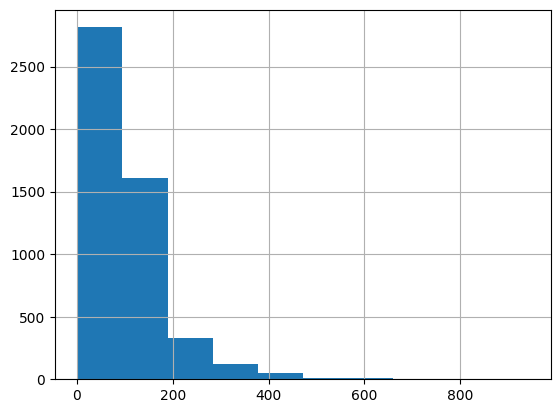

In [11]:
doc_len = df['lyrics'].apply(lambda x: len(x.split()))
doc_len.hist()

In [12]:
th = 300
n_doc_len_gt_th = (doc_len > th).sum()
print(f'Broj tekstova koji imaju vise od {th} reci: {n_doc_len_gt_th} ({n_doc_len_gt_th * 100/len(doc_len):.2}%)')
print(f'Tekstovi duzi od {th} reci bice skraceni (truncate), a kraci dopunjeni (padded)')

Broj tekstova koji imaju vise od 300 reci: 171 (3.5%)
Tekstovi duzi od 300 reci bice skraceni (truncate), a kraci dopunjeni (padded)


In [13]:
df.columns

Index(['track', 'artist', 'number_of_emotion_tags', 'valence_tags',
       'arousal_tags', 'dominance_tags', 'spotify_id', 'seeds_array',
       'artist_name', 'track_name', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence', 'genres', 'Comedy', 'Soundtrack', 'Indie',
       'Jazz', 'Pop', 'Electronic', 'Children’s Music', 'Folk', 'Hip-Hop',
       'Rock', 'Alternative', 'Classical', 'Rap', 'World', 'Soul', 'Blues',
       'R&B', 'Anime', 'Reggaeton', 'Ska', 'Reggae', 'Dance', 'Country',
       'Opera', 'Movie', 'Children's Music', 'A Capella', 'artist_track',
       'genius_url', 'lyrics', 'sentiment'],
      dtype='object')

In [14]:
minmax_scale_cols = ['tempo', 'number_of_emotion_tags', 'valence_tags', 'arousal_tags', 'dominance_tags']
df[minmax_scale_cols] = MinMaxScaler().fit_transform(df[minmax_scale_cols])
df[minmax_scale_cols].describe()

,tempo,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags
count,4955.000000,4955.000000,4955.000000,4955.000000,4955.000000
mean,0.461059,0.205180,0.702058,0.598063,0.742637
std,0.160219,0.187390,0.170696,0.148279,0.135512
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.336838,0.033333,0.597761,0.499935,0.670659
50%,0.455838,0.133333,0.734942,0.592599,0.772431
75%,0.564919,0.333333,0.834908,0.701480,0.832460
max,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

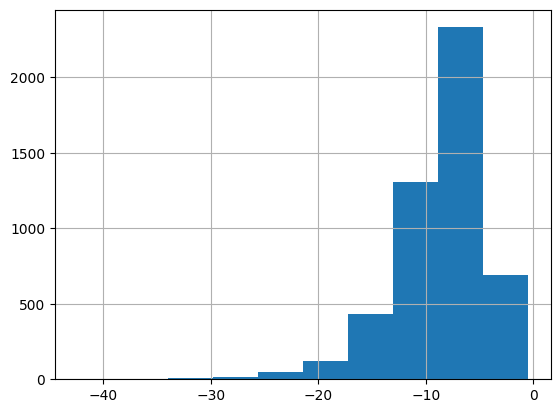

In [15]:
df['loudness'].hist()

Jacina zvuka je relativna velicina. 0 je najjaci zvuk i kraj referentne skale. Jacina zvuka treba da se skalira u procente od maksimalne jacine.

<AxesSubplot:>

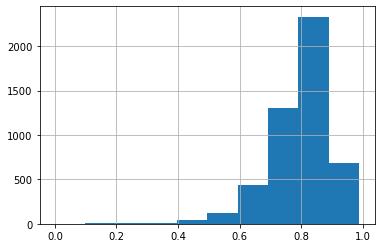

In [40]:
df['loudness'] = (1 - df['loudness'] / df['loudness'].min())
df['loudness'].hist()

<Axes: >

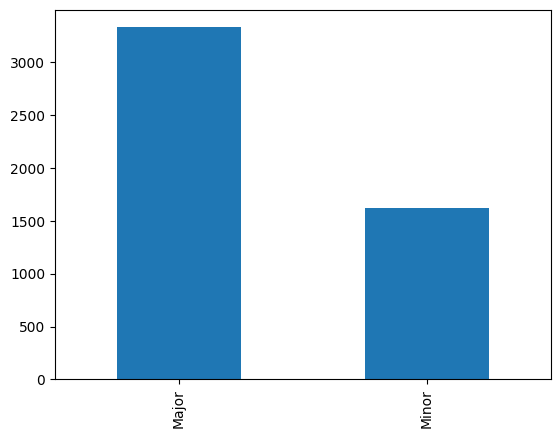

In [17]:
df['mode'].value_counts().plot.bar()

In [18]:
df['mode'] = LabelEncoder().fit_transform(df['mode'])

<Axes: >

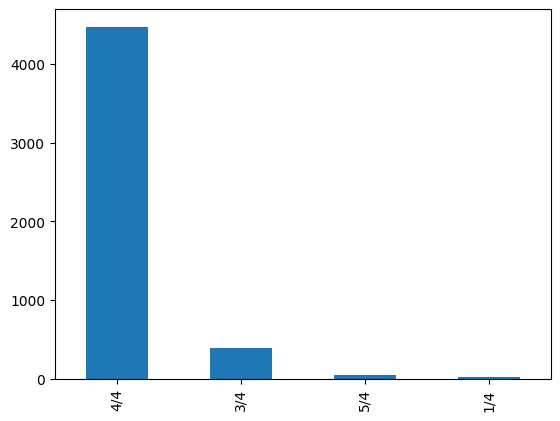

In [19]:
df['time_signature'].value_counts().plot.bar()

In [20]:
df = pd.get_dummies(df, columns=['time_signature'])

In [21]:
df.columns

Index(['track', 'artist', 'number_of_emotion_tags', 'valence_tags',
       'arousal_tags', 'dominance_tags', 'spotify_id', 'seeds_array',
       'artist_name', 'track_name', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence',
       'genres', 'Comedy', 'Soundtrack', 'Indie', 'Jazz', 'Pop', 'Electronic',
       'Children’s Music', 'Folk', 'Hip-Hop', 'Rock', 'Alternative',
       'Classical', 'Rap', 'World', 'Soul', 'Blues', 'R&B', 'Anime',
       'Reggaeton', 'Ska', 'Reggae', 'Dance', 'Country', 'Opera', 'Movie',
       'Children's Music', 'A Capella', 'artist_track', 'genius_url', 'lyrics',
       'sentiment', 'time_signature_1/4', 'time_signature_3/4',
       'time_signature_4/4', 'time_signature_5/4'],
      dtype='object')

In [41]:
def train_val_test_prep(df):
    df = df.drop(columns=['key', 'spotify_id', 'seeds_array', 'artist_name', 'track_name', 'popularity', 'duration_ms', 'A Capella', 'artist_track', 'genius_url'])
    encoder = LabelEncoder().fit(df['sentiment'])
    labels = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    df['target'] = encoder.transform(df['sentiment'])
        
    train, test = train_test_split(df, test_size = 0.1, stratify=df['target'], random_state = 0)
    train, val = train_test_split(train, test_size = 0.111, stratify=train['target'], random_state = 0)

    return train, val, test

In [42]:
train, val, test = train_val_test_prep(df)

# x_train, y_train = RandomUnderSampler(random_state=0).fit_resample(train.drop(columns=['target', 'sentiment']), train['target'])
# x_train, y_train = RandomOverSampler(random_state=0).fit_resample(train.drop(columns=['target', 'sentiment']), train['target'])
# lyrics_train, meta_train, y_train = x_train['lyrics'], x_train.drop(columns=['lyrics']), y_train

lyrics_train, meta_train, y_train = train['lyrics'], train.drop(columns=['lyrics', 'target', 'sentiment']), train['target']
lyrics_val, meta_val, y_val =  val['lyrics'], val.drop(columns=['lyrics', 'target', 'sentiment']), val['target']
lyrics_test, meta_test, y_test =  test['lyrics'], test.drop(columns=['lyrics', 'target', 'sentiment']), test['target']

In [31]:
print(test.shape)
print(test["sentiment"].value_counts())
test.head()

(496, 47)
relaxed_atmospheric    176
upbeat_fun             162
sad_melancholic         81
intense_aggressive      39
dark_gritty             38
Name: sentiment, dtype: int64


,track,artist,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,acousticness,danceability,energy,instrumentalness,...,Ska,Reggae,Dance,Country,Opera,Movie,Children's Music,lyrics,sentiment,target
3802,Let Me Be Myself,3 Doors Down,4,3.822353,4.067647,4.183529,0.00468,0.496,0.675,0.000012,...,0,0,0,0,0,0,0,[Verse 1]\r\nI guess I just got lost\r\nBeing ...,sad_melancholic,3
3834,How To Fight Loneliness,Wilco,17,3.580000,3.656182,3.998909,0.59600,0.692,0.378,0.110000,...,0,0,0,1,0,0,0,[Verse 1]\r\nHow to fight loneliness\r\nSmile ...,sad_melancholic,3
1877,Get Over It,OK Go,11,7.327966,5.634407,6.331017,0.00127,0.389,0.767,0.000000,...,0,0,0,0,0,0,0,"[Verse 1]\r\nLot of knots, lot of snags\r\nLot...",upbeat_fun,4
1400,Deja Vu,Eminem,4,7.075000,4.843333,5.710000,0.20900,0.702,0.866,0.000000,...,0,0,0,0,0,0,0,"[Intro: Matthew St. Patrick]\r\nDMC, we have a...",upbeat_fun,4
3453,Nothing Even Matters,Lauryn Hill feat. D'Angelo,11,6.766927,4.242458,6.227709,0.70100,0.539,0.363,0.000003,...,0,0,0,0,0,0,0,"[Intro: D'Angelo,\r\nLauryn Hill\r\n]\r\nOh, o...",relaxed_atmospheric,2


In [43]:
val.to_csv("data/val_ds.csv", index=False)

In [44]:
test.to_csv("data/test_ds.csv", index=False)

## RNN embedding

In [29]:
def plot_train_history(hist):
    plt.plot(hist.history['loss'], '-', label='Training loss')
    plt.plot(hist.history['val_loss'], '-', label='Validation loss')

    # add axis labels and title
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and Validation Loss')

    # add legend
    plt.legend()

    # show the plot
    plt.show()

In [82]:
max_seq_len = th   # Sequence length to pad/trunc the outputs to.
embedding_dim = 100
n_classes = 5

def get_rnn(rnn_layer, docs, meta):
    meta_input = Input(shape=(meta.shape[1],))
    
    nlp_input = Input(shape=(1, ), dtype=tf.string)

    text_dataset = Dataset.from_tensor_slices(docs)
    vectorize = TextVectorization(output_sequence_length=max_seq_len)
    vectorize.adapt(text_dataset.batch(batch_size=64))
    vectorized = vectorize(nlp_input)
    
    embed = Embedding(vectorize.vocabulary_size(), embedding_dim, input_length=max_seq_len, trainable=True)
    embedded = embed(vectorized)
    nlp_out = rnn_layer(embedded)
    to_classify = concatenate([nlp_out, meta_input])
    clf = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(to_classify)
    clf = Dropout(0.5)(clf)
    clf = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    clf = Dropout(0.5)(clf)
    output = Dense(n_classes, activation='softmax')(clf)
    
    model = Model(inputs=[nlp_input, meta_input], outputs=[output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [83]:
lstm = LSTM(128, dropout=0.2)
ann = get_rnn(lstm, lyrics_train, meta_train)

In [84]:
gru = GRU(128, dropout=0.2)
ann = get_rnn(gru, lyrics_train, meta_train)

Epoch 1/200
31/31 [==============================] - 10s 234ms/step - loss: 1.4849 - accuracy: 0.3428 - val_loss: 1.3870 - val_accuracy: 0.4707
Epoch 2/200
31/31 [==============================] - 5s 169ms/step - loss: 1.3996 - accuracy: 0.4036 - val_loss: 1.3227 - val_accuracy: 0.4727
Epoch 3/200
31/31 [==============================] - 5s 159ms/step - loss: 1.3459 - accuracy: 0.4334 - val_loss: 1.2638 - val_accuracy: 0.4707
Epoch 4/200
31/31 [==============================] - 5s 169ms/step - loss: 1.3072 - accuracy: 0.4541 - val_loss: 1.2291 - val_accuracy: 0.4727
Epoch 5/200
31/31 [==============================] - 4s 147ms/step - loss: 1.2774 - accuracy: 0.4740 - val_loss: 1.2037 - val_accuracy: 0.5374
Epoch 6/200
31/31 [==============================] - 5s 148ms/step - loss: 1.2394 - accuracy: 0.5000 - val_loss: 1.1534 - val_accuracy: 0.5556
Epoch 7/200
31/31 [==============================] - 5s 145ms/step - loss: 1.2059 - accuracy: 0.5111 - val_loss: 1.1350 - val_accuracy: 0.559

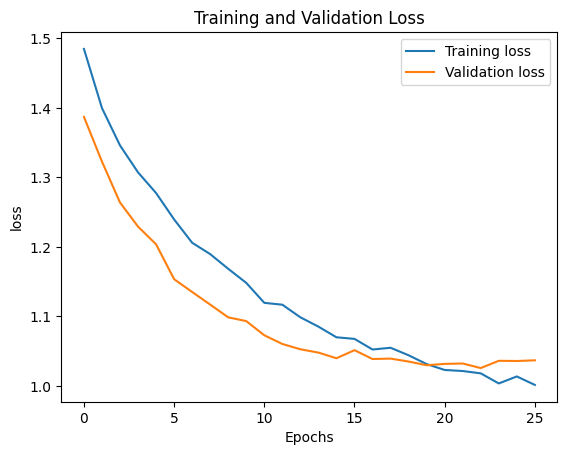

16/16 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.33      0.26      0.29        38
           1       0.47      0.54      0.50        39
           2       0.61      0.57      0.59       176
           3       0.61      0.67      0.64        81
           4       0.63      0.65      0.64       162

    accuracy                           0.59       496
   macro avg       0.53      0.54      0.53       496
weighted avg       0.58      0.59      0.58       496



In [85]:
hist = ann.fit(
    [lyrics_train, meta_train], to_categorical(y_train),  
    validation_data=([lyrics_val, meta_val], to_categorical(y_val)), 
    callbacks=[EarlyStopping(patience=3)],
    epochs=200,
    batch_size=128)
plot_train_history(hist)
print(classification_report(y_test, np.argmax(ann.predict([lyrics_test, meta_test]), axis=-1)))

## Word2Vec, Glove

In [ ]:
wg = pd.read_csv('word_vector_embeddings_final.csv', index_col=0)
print(wg.shape)
wg.head()

In [ ]:
wg_df = pd.merge(df, wg[['artist', 'track', 'lyrics_glove', 'lyrics_w2v', 'lyrics_glove_twitter']], on=['artist', 'track'], how='inner')
wg_df.columns

In [25]:
train, val, test = train_val_test_prep(wg_df)

In [103]:
def embed_to_np(embed):
    to_np = lambda x: np.fromstring(x[1:-1], sep=' ')
    return np.array(embed.apply(to_np).to_list())

# w2v
# embed_type = 'lyrics_w2v'
# glove
embed_type = 'lyrics_glove'
# glove_twitter
# embed_type = 'lyrics_glove_twitter'

embed_dim = embed_to_np(wg_df[embed_type]).shape[1]

print(f'Embed type: {embed_type}  Embed dim: {embed_dim}')

non_meta_cols = ['lyrics', 'target', 'sentiment', 'lyrics_w2v', 'lyrics_glove', 'lyrics_glove_twitter']

meta_train, meta_val, meta_test = train.drop(columns=non_meta_cols), val.drop(columns=non_meta_cols), test.drop(columns=non_meta_cols)
y_train, y_val, y_test = train['target'], val['target'], test['target']
embed_train, embed_val, embed_test = embed_to_np(train[embed_type]), embed_to_np(val[embed_type]), embed_to_np(test[embed_type])
print(f'Train_size: {y_train.shape[0]}, Val_size: {y_val.shape[0]}, Test_size: {y_test.shape[0]}')

Embed type: lyrics_glove  Embed dim: 300
Train_size: 3964, Val_size: 495, Test_size: 496


In [106]:
n_classes = 5
def get_ann_wg(embed_dim, meta_dim):
    meta_input = Input(shape=(meta_dim,))
    nlp_input = Input(shape=(embed_dim, ))

    to_classify = concatenate([nlp_input, meta_input])
    clf = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(to_classify)
    clf = Dropout(0.5)(clf)
    clf = BatchNormalization()(clf)

    clf = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    clf = Dropout(0.5)(clf)
    clf = BatchNormalization()(clf)
    
    output = Dense(n_classes, activation='softmax')(clf)
    
    model = Model(inputs=[nlp_input, meta_input], outputs=[output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Epoch 1/200
62/62 [==============================] - 3s 12ms/step - loss: 2.0040 - accuracy: 0.2185 - val_loss: 1.5280 - val_accuracy: 0.3273
Epoch 2/200
62/62 [==============================] - 0s 8ms/step - loss: 1.7401 - accuracy: 0.2896 - val_loss: 1.4925 - val_accuracy: 0.3434
Epoch 3/200
62/62 [==============================] - 0s 6ms/step - loss: 1.6009 - accuracy: 0.3466 - val_loss: 1.4295 - val_accuracy: 0.4141
Epoch 4/200
62/62 [==============================] - 0s 5ms/step - loss: 1.5237 - accuracy: 0.3746 - val_loss: 1.4041 - val_accuracy: 0.4222
Epoch 5/200
62/62 [==============================] - 0s 6ms/step - loss: 1.4465 - accuracy: 0.4062 - val_loss: 1.3380 - val_accuracy: 0.4505
Epoch 6/200
62/62 [==============================] - 0s 6ms/step - loss: 1.4057 - accuracy: 0.4188 - val_loss: 1.3223 - val_accuracy: 0.4667
Epoch 7/200
62/62 [==============================] - 0s 5ms/step - loss: 1.3699 - accuracy: 0.4339 - val_loss: 1.2887 - val_accuracy: 0.4949
Epoch 8/200


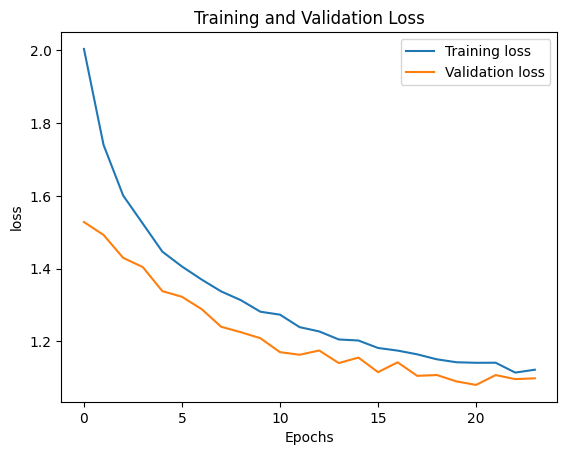

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.54      0.18      0.27        38
           1       0.60      0.38      0.47        39
           2       0.68      0.50      0.58       176
           3       0.61      0.67      0.64        81
           4       0.54      0.80      0.65       162

    accuracy                           0.59       496
   macro avg       0.59      0.51      0.52       496
weighted avg       0.61      0.59      0.58       496



In [107]:
ann = get_ann_wg(embed_dim, meta_train.shape[1])

hist = ann.fit(
    [embed_train, meta_train], to_categorical(y_train),  
    validation_data=([embed_val, meta_val], to_categorical(y_val)), 
    callbacks=[EarlyStopping(patience=3)],
    epochs=200,
    batch_size=64)
plot_train_history(hist)
print(classification_report(y_test, np.argmax(ann.predict([embed_test, meta_test]), axis=-1)))

##  BERT, ELMO

In [108]:
bert_df = pd.read_csv('music_bert_2.csv', index_col=0)[['track', 'artist', 'embedded_lyrics']]
print(bert_df.shape)
bert_df.head()

(4955, 3)


,track,artist,embedded_lyrics
0,'Till I Collapse,Eminem,[ 1.54634953e-01 -5.11078909e-03 5.06923676e-...
1,St. Anger,Metallica,[ 1.72974318e-02 1.21722564e-01 4.57439095e-...
2,Die MF Die,Dope,[ 4.53510493e-01 2.41083160e-01 3.90855342e-...
3,Step Up,Drowning Pool,[ 1.94582716e-01 -8.45494941e-02 3.98656428e-...
4,Feedback,Kanye West,[ 2.07781702e-01 2.55387686e-02 4.91093695e-...


In [109]:
bert_df = pd.merge(df, bert_df, on=['artist', 'track'], how='inner')
bert_df.columns

Index(['track', 'artist', 'number_of_emotion_tags', 'valence_tags',
       'arousal_tags', 'dominance_tags', 'spotify_id', 'seeds_array',
       'artist_name', 'track_name', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence',
       'genres', 'Comedy', 'Soundtrack', 'Indie', 'Jazz', 'Pop', 'Electronic',
       'Children’s Music', 'Folk', 'Hip-Hop', 'Rock', 'Alternative',
       'Classical', 'Rap', 'World', 'Soul', 'Blues', 'R&B', 'Anime',
       'Reggaeton', 'Ska', 'Reggae', 'Dance', 'Country', 'Opera', 'Movie',
       'Children's Music', 'A Capella', 'artist_track', 'genius_url', 'lyrics',
       'sentiment', 'time_signature_1/4', 'time_signature_3/4',
       'time_signature_4/4', 'time_signature_5/4', 'embedded_lyrics'],
      dtype='object')

In [110]:
train, val, test = train_val_test_prep(bert_df)

In [111]:
def embed_to_np(embed):
    to_np = lambda x: np.fromstring(x[1:-1], sep=' ')
    return np.array(embed.apply(to_np).to_list())

embed_type = 'embedded_lyrics'

embed_dim = embed_to_np(bert_df[embed_type]).shape[1]

print(f'Embed type: {embed_type}  Embed dim: {embed_dim}')

non_meta_cols = ['lyrics', 'target', 'sentiment', 'embedded_lyrics']

meta_train, meta_val, meta_test = train.drop(columns=non_meta_cols), val.drop(columns=non_meta_cols), test.drop(columns=non_meta_cols)
y_train, y_val, y_test = train['target'], val['target'], test['target']
embed_train, embed_val, embed_test = embed_to_np(train[embed_type]), embed_to_np(val[embed_type]), embed_to_np(test[embed_type])
print(f'Train_size: {y_train.shape[0]}, Val_size: {y_val.shape[0]}, Test_size: {y_test.shape[0]}')

Embed type: embedded_lyrics  Embed dim: 768
Train_size: 3964, Val_size: 495, Test_size: 496


In [151]:
n_classes = 5
def get_ann_bert(embed_dim, meta_dim):
    print(f'Embed dim: {embed_dim}  Meta dim: {meta_dim}')
    meta_input = Input(shape=(meta_dim,))
    nlp_input = Input(shape=(embed_dim, ))

    to_classify = concatenate([nlp_input, meta_input])
    clf = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(to_classify)
    clf = Dropout(0.5)(clf)
    clf = BatchNormalization()(clf)
    clf = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    clf = Dropout(0.5)(clf)
    clf = BatchNormalization()(clf)
    clf = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    clf = Dropout(0.5)(clf)
    clf = BatchNormalization()(clf)
    clf = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    clf = Dropout(0.5)(clf)
    clf = BatchNormalization()(clf)


    # clf = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(to_classify)
    # clf = Dropout(0.5)(clf)
    # # clf = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    # clf = Dropout(0.5)(clf)
    # clf = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    # clf = Dropout(0.5)(clf)
    # clf = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    # clf = Dropout(0.5)(clf)
    # clf = Dense(16, activation='relu', kernel_regularizer=l2(0.0001))(clf)
    # clf = Dropout(0.5)(clf)
    output = Dense(n_classes, activation='softmax')(clf)
    
    model = Model(inputs=[nlp_input, meta_input], outputs=[output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Embed dim: 768  Meta dim: 44
Epoch 1/200
31/31 [==============================] - 5s 17ms/step - loss: 2.2120 - accuracy: 0.2263 - val_loss: 1.6170 - val_accuracy: 0.3758
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 2.0132 - accuracy: 0.2404 - val_loss: 1.5693 - val_accuracy: 0.3556
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 1.8973 - accuracy: 0.2702 - val_loss: 1.5631 - val_accuracy: 0.3495
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 1.8002 - accuracy: 0.2982 - val_loss: 1.5418 - val_accuracy: 0.3535
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 1.7472 - accuracy: 0.3030 - val_loss: 1.5292 - val_accuracy: 0.3636
Epoch 6/200
31/31 [==============================] - 0s 8ms/step - loss: 1.6957 - accuracy: 0.3320 - val_loss: 1.5168 - val_accuracy: 0.3939
Epoch 7/200
31/31 [==============================] - 0s 9ms/step - loss: 1.6370 - accuracy: 0.3502 - val_loss: 1.5010 - val_

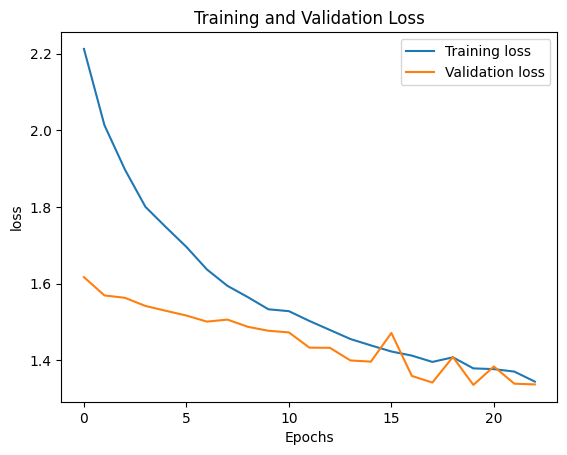

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.44      0.11      0.17        38
           1       0.33      0.03      0.05        39
           2       0.47      0.85      0.60       176
           3       0.66      0.41      0.50        81
           4       0.67      0.48      0.56       162

    accuracy                           0.53       496
   macro avg       0.51      0.37      0.38       496
weighted avg       0.55      0.53      0.49       496



In [152]:
ann = get_ann_bert(embed_dim, meta_train.shape[1])

hist = ann.fit(
    [embed_train, meta_train], to_categorical(y_train),  
    validation_data=([embed_val, meta_val], to_categorical(y_val)), 
    callbacks=[EarlyStopping(patience=3)],
    epochs=200,
    batch_size=128)
plot_train_history(hist)
print(classification_report(y_test, np.argmax(ann.predict([embed_test, meta_test]), axis=-1)))